In [47]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from mpl_toolkits.mplot3d import Axes3D

Simple data matrix with N = 18, d = 3

In [48]:
D = np.array([[1,0, 1],
              [2,0, 1],
              [3,0, 1],
              [3,3, 1],
              [4,3, 1],
              [5,3, 1],
              [5,6, 1],
              [6,6, 1],
              [7,6, 1],
              [1,0, 0],
              [2,0, 0],
              [3,0, 0],
              [3,3, 0],
              [4,3, 0],
              [5,3, 0],
              [5,6, 0],
              [6,6, 0],
              [7,6, 0]])

D = D - np.mean(D, axis = 0) #center the data
print(D)

[[-3.  -3.   0.5]
 [-2.  -3.   0.5]
 [-1.  -3.   0.5]
 [-1.   0.   0.5]
 [ 0.   0.   0.5]
 [ 1.   0.   0.5]
 [ 1.   3.   0.5]
 [ 2.   3.   0.5]
 [ 3.   3.   0.5]
 [-3.  -3.  -0.5]
 [-2.  -3.  -0.5]
 [-1.  -3.  -0.5]
 [-1.   0.  -0.5]
 [ 0.   0.  -0.5]
 [ 1.   0.  -0.5]
 [ 1.   3.  -0.5]
 [ 2.   3.  -0.5]
 [ 3.   3.  -0.5]]


In [49]:
def pca(inputs, k = 2):
    X = inputs
    N, d = X.shape
    M = 1/N * np.dot(np.transpose(X), X) #covariance matrix
    print(M)
    e, v = LA.eig(M) #e = eigenvalues, v = eigenvectors
    idx = e.argsort()[::-1]   
    e = e[idx]
    v = v[:,idx]
    print("Eigenvectors:")
    print(v)
    P = v[:k,:].reshape(d, k) #take k first principal components i.e. first k rows
    X_p = np.dot(X, P)
    X_r = np.dot(X_p, np.transpose(P))

    return (X_p, X_r, P)

In [50]:
D_p, D_r, U = pca(D, k = 1)

[[3.33333333 4.         0.        ]
 [4.         6.         0.        ]
 [0.         0.         0.25      ]]
Eigenvectors:
[[-0.58471028 -0.81124219  0.        ]
 [-0.81124219  0.58471028  0.        ]
 [ 0.          0.          1.        ]]


Principal Components
[[-0.58471028]
 [-0.81124219]
 [ 0.        ]]
MSE 0.23343215103627588

Original (red) and reproduced (blue) data:


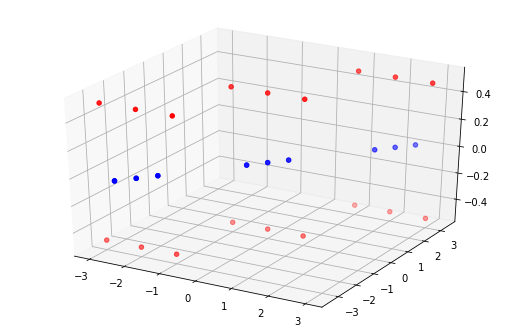

Projected Data


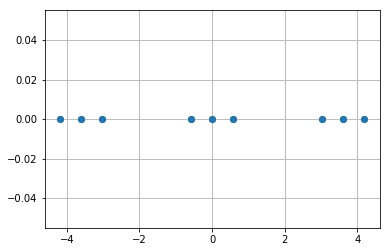

In [51]:
print("Principal Components")
print(U)
mse = np.mean((D - D_r)**2)
print("MSE", mse)

print("\nOriginal (red) and reproduced (blue) data:")
plt.figure(figsize = (20, 20))
ax = plt.subplot(321, projection='3d')
ax.scatter(D[:,0], D[:,1], D[:,2], c='r')
#ax = plt.subplot(322, projection='3d')
ax.scatter(D_r[:,0], D_r[:,1], D_r[:,2], c='b')
plt.show()

print("Projected Data")
plt.plot(D_p, np.zeros(18), 'o')
plt.grid(True)
plt.show()

Complete the below function s.t. the autoencoder has one hidden layer with k units and a linear activation function.

In [52]:
def autoencoder(inputs, k = 2, t = 1e-5, maxIter=8000): #t = threshold for loss
    N, d = inputs.shape
    X = tf.placeholder(tf.float32, [N, d])
    W_e = tf.Variable(tf.random_normal([d, k]))
    X_encoded = tf.matmul(X, W_e)
    W_d = tf.Variable(tf.random_normal([k, d]))
    X_out = tf.matmul(X_encoded, W_d)
    
    loss = tf.reduce_mean(tf.square(X - X_out))  # calculate the mean squared error 
    optimizer = tf.train.AdamOptimizer().minimize(loss) #learning rate

    i= 0
    with tf.Session() as sess:
        sess.run(tf.initializers.global_variables())
        delta = np.Inf 
        l = np.Inf 
        i= 0
        while (delta > t) and (i < maxIter):
            _, l_cur = sess.run([optimizer, loss], feed_dict={X: inputs})
            delta = l - l_cur
            if (i == 0)  or (i+1) %500 == 0:
                print("Iteration %d. Loss: %.3f" % (i+1, l_cur))
            delta = l - l_cur
            l = l_cur
            i += 1
        print("Iteration %d. Final loss: %.3f" % (i, l_cur))
        
        X_r, X_p = sess.run([X_out, X_encoded], feed_dict={X:inputs}) #reconstructed and projected data
        W = W_e.eval()
        return (X_r, X_p, W)

In [53]:
A_r, A_p, W = autoencoder(D, k=1)

Iteration 1. Loss: 11.353
Iteration 500. Loss: 4.411
Iteration 1000. Loss: 2.964
Iteration 1500. Loss: 1.447
Iteration 2000. Loss: 0.278
Iteration 2500. Loss: 0.253
Iteration 2601. Final loss: 0.252


Weights
[[ 0.71423274]
 [ 0.49201998]
 [-0.0033326 ]]
MSE 0.2515063270351416

Original (red) and reproduced (blue) data:


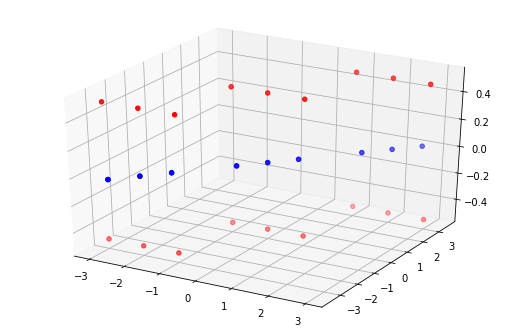

Projected data


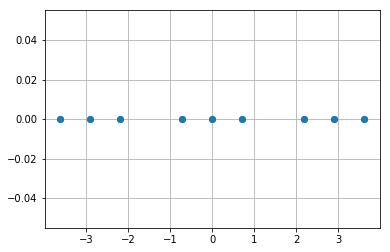

In [54]:
print("Weights")
print(W)
mse = np.mean((D - A_r)**2)
print("MSE", mse)

print("\nOriginal (red) and reproduced (blue) data:")
plt.figure(figsize = (20, 20))
ax = plt.subplot(321, projection='3d')
ax.scatter(D[:,0], D[:,1], D[:,2], c='r')
#ax = plt.subplot(322, projection='3d')
ax.scatter(A_r[:,0], A_r[:,1], A_r[:,2], c='b')
plt.show()

print("Projected data")
plt.plot(A_p[:,0],np.zeros(18), 'o')
plt.grid(True)
plt.show()

Compare the results!

Apply the above simple autoencoder to the digit 3 of the MNIST dataset and plot the results. What could you improve?

In [55]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [56]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

#select images with label 3
label = 3   
idx = np.where(Y_train == label)
img = X_train[idx]
print(img.shape)

#flatten images
img = img.reshape(len(img), np.prod(img.shape[1:]))
print(img.shape)

(6131, 28, 28)
(6131, 784)


Iteration 1. Loss: 320751168.000
Iteration 500. Loss: 33349644.000
Iteration 1000. Loss: 15275085.000
Iteration 1500. Loss: 8508691.000
Iteration 2000. Loss: 5166566.500
Iteration 2500. Loss: 3289922.250
Iteration 3000. Loss: 2159080.000
Iteration 3500. Loss: 1445216.750
Iteration 4000. Loss: 978317.062
Iteration 4500. Loss: 664126.625
Iteration 5000. Loss: 449621.875
Iteration 5500. Loss: 302859.000
Iteration 6000. Loss: 202373.391
Iteration 6500. Loss: 133888.031
Iteration 7000. Loss: 87684.016
Iteration 7500. Loss: 56925.836
Iteration 8000. Loss: 36718.766
Iteration 8500. Loss: 23605.367
Iteration 9000. Loss: 15230.309
Iteration 9500. Loss: 9960.734
Iteration 10000. Loss: 6699.642
Iteration 10112. Final loss: 6182.554


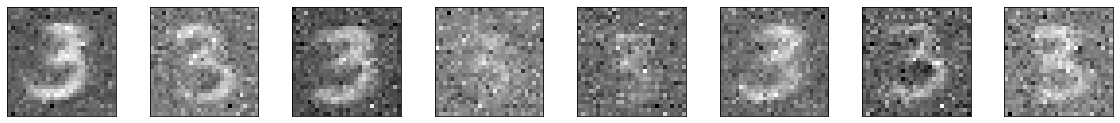

In [57]:
#apply autoencoder to image data 
imgA_r, imgA_p, W = autoencoder(img, k=50, maxIter = 50000)

m = 8
plt.figure(figsize=(20, 2))
#Input images
plt.figure(1, figsize=(20, 2))
for i in range(1, m+1):
    ax = plt.subplot(1, m, i)
    plt.imshow(imgA_r[i].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Additional: Singular value decomposition

In [58]:
def svd(inputs, k):
    N, d = inputs.shape
    U, s, V = np.linalg.svd(inputs, full_matrices=True)
    S = np.zeros((N, d))
    S[:d, :d] = np.diag(s)
    #take k eigenvectors
    k = 32 
    S_p = S[:k, :k] #first k singular values
    U_p = U[: , :k] #first k columns
    V_p = V[:k, :]  #first k eigenvectors
    X_r = np.dot(U_p, np.dot(S_p, V_p))  #reproduced image
    return (X_r, V_p)

Eigenvectors
[[ 1.35504280e-18 -2.22044605e-16  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.81123897e-18  0.00000000e+00  5.55111512e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.54178398e-18 -1.66533454e-16 -3.88578059e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.49617785e-18  4.16333634e-17  5.55111512e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
MSE 866.4429334518466


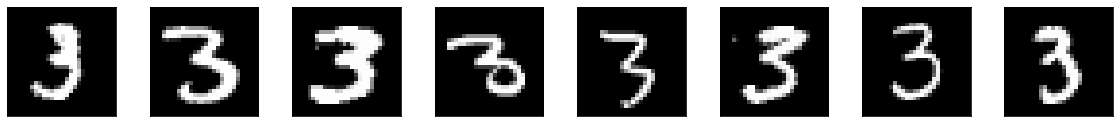

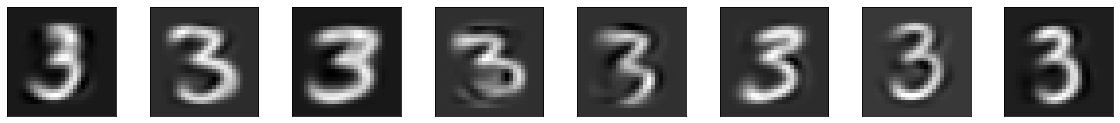

In [59]:
#Perform SVD
img_r, V = svd(img, 50)

print("Eigenvectors")
print(V[0:4])

mse = np.mean((img - img_r)**2)
print("MSE", mse)

#plot some images
m = 8
#Input images
plt.figure(1, figsize=(20, 2))
for i in range(1, m+1):
    ax = plt.subplot(1, m, i)
    plt.imshow(img[i].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(2, figsize=(20, 2))
for i in range(1, m+1):
    ax = plt.subplot(1, m, i)
    plt.imshow(img_r[i].reshape(28, 28), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()